In [242]:
from datetime import datetime
from time import sleep
import requests
import numpy as np

In [243]:
def t2s(the_time):
    return datetime.fromtimestamp(int(the_time)).strftime('%Y/%m/%d %H:%M')

In [ ]:
data = []

# データ取得のための設定

In [254]:
num = 1440 - 1 # 60*24 - 1

d = datetime.now()
last_time = datetime(d.year, d.month, d.day, 23, 59)
#last_time = datetime(2017, 1, 2, 23, 59)   # 日付を指定する場合

stop_time = int(datetime(2017, 1, 1, 0, 0).strftime('%s'))　# データの最初の時刻

frame_etime = last_time.strftime('%s') # unix time (秒)
frame_stime = str( int(frame_etime) - 60*num )

## データ取得
途中で異常終了する場合は、上記の last_time を変更して再実行

In [255]:
while True:
    print("{} - {}  ( {} - {} )".format(t2s(frame_stime), t2s(frame_etime), frame_stime, frame_etime))
    com = "https://www.bitmex.com/api/udf/history?symbol=XBTUSD&resolution=1&from={0:}&to={1:}".format(frame_stime, frame_etime)
    ret = requests.get(com)
    d = ret.json()
    if d['s'] != 'ok':
        print("Failed for the time frame ({} - {})".format(frame_stime, frame_etime))
    dd = list(zip(d['t'], d['o'], d['h'], d['l'], d['c'], d['v']))
    data.extend(dd)
    
    frame_etime = dd[0][0]
    frame_stime = str( int(frame_etime) - 60*num )
    if int(frame_stime) < stop_time:
        break
    sleep(5)

2017/01/02 00:00 - 2017/01/02 23:59  ( 1483282800 - 1483369140 )
2017/01/01 00:00 - 2017/01/01 23:59  ( 1483196400 - 1483282740 )


### データの確認

In [265]:
len(data)

738090

In [266]:
data.sort()

In [275]:
int(data[1][0]) -  int(data[0][0])


60

In [276]:
data[0][0]

1483228740

In [308]:
data2 = []
for i in range(1,len(data)):
    if int(data[i][0]) - int(data[i-1][0]) == 60:
        print(t2s(data[i-1][0]), data[i-1][0], t2s(data[i][0]), data[i][0])
        data2.append(data[i])
    if  int(data[i][0]) - int(data[i-1][0]) > 60:
        print("Insufficient Data found round {}", data[i][0] )
print(len(data2))


736136


In [309]:
data2

[(1483228800, 968.29, 968.76, 968.49, 968.7, 12993),
 (1483228860, 968.7, 968.7, 967.2, 968.43, 73800),
 (1483228920, 968.43, 968, 967.21, 967.21, 3500),
 (1483228980, 967.21, 967.21, 966.74, 966.97, 15969),
 (1483229040, 966.97, 966.97, 966.97, 966.97, 300),
 (1483229100, 966.97, 967, 967, 967, 13231),
 (1483229160, 967, 966.89, 966.89, 966.89, 500),
 (1483229220, 966.89, 966.89, 966.89, 966.89, 0),
 (1483229280, 966.89, 966.89, 966.89, 966.89, 0),
 (1483229340, 966.89, 966.89, 966.89, 966.89, 0),
 (1483229400, 966.89, 966.89, 966.89, 966.89, 0),
 (1483229460, 966.89, 966.64, 966.05, 966.05, 12900),
 (1483229520, 966.05, 965.86, 964.99, 965, 103237),
 (1483229580, 965, 965, 965, 965, 0),
 (1483229640, 965, 964.86, 964.86, 964.86, 8000),
 (1483229700, 964.86, 964.86, 964.86, 964.86, 0),
 (1483229760, 964.86, 964.99, 964.99, 964.99, 3000),
 (1483229820, 964.99, 964.8, 964.8, 964.8, 1),
 (1483229880, 964.8, 964.8, 964.8, 964.8, 0),
 (1483229940, 964.8, 964.8, 964.8, 964.8, 0),
 (14832300

In [310]:
t = list(zip(*data2))

In [311]:
%matplotlib inline
import matplotlib.pyplot as plt

### 時刻データが昇順になっているかの確認

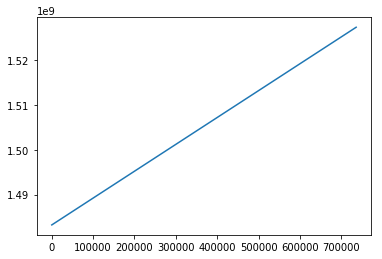

In [312]:
plt.plot(t[0])

### 始値の確認

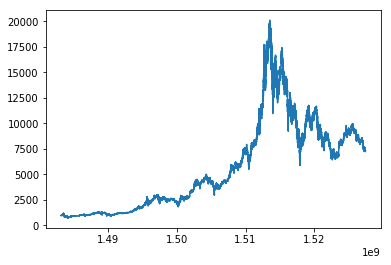

In [313]:
plt.plot(t[0],t[1])

# CSV ファイルへの保存

In [315]:
import csv

In [316]:
with open("xbtusd_1m.csv", "w") as file:
    writer = csv.writer(file, lineterminator='\n') # 改行コード（\n）を指定しておく
    writer.writerows(data2)

# MySQL データベースへの保存

In [371]:
import mysql.connector

cnt = mysql.connector.connect(
    host='localhost',
    port='3306',
    db='bitmex',
    user='bitmex',
    password='bitmex',
    charset='utf8'
)

cur = cnt.cursor()

In [352]:
cur.execute('create table xbtusd_1m (t int(11), o float(6,1), h float(6,1), l float(6,1), c float(6,1), v int(11))' )
cnt.commit()

In [353]:
sql = 'insert into xbtusd_1m values (%s, %s, %s, %s, %s, %s)'


##  データ追加
高速化のため、10000行ずつの塊で追加

In [354]:
step = 10000
for i in range(0, len(data2), step):
    j = i + step 
    if j > len(data2):
        j = len(data2)
    print(i,j)
    cur.executemany(sql, data2[i:j])
    cnt.commit()

0 10000
10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000
210000 220000
220000 230000
230000 240000
240000 250000
250000 260000
260000 270000
270000 280000
280000 290000
290000 300000
300000 310000
310000 320000
320000 330000
330000 340000
340000 350000
350000 360000
360000 370000
370000 380000
380000 390000
390000 400000
400000 410000
410000 420000
420000 430000
430000 440000
440000 450000
450000 460000
460000 470000
470000 480000
480000 490000
490000 500000
500000 510000
510000 520000
520000 530000
530000 540000
540000 550000
550000 560000
560000 570000
570000 580000
580000 590000
590000 600000
600000 610000
610000 620000
620000 630000
630000 640000
640000 650000
650000 660000
660000 670000
670000 680000
680000 690000
690000 700000
700000 710000
710000 720000
720000 730000
7

## 正しく格納出来ているか確認

In [355]:
data2[len(data2)-1]

(1527396900, 7301.5, 7302, 7301.5, 7302, 32445)

In [356]:
data2[-1]

(1527396900, 7301.5, 7302, 7301.5, 7302, 32445)

In [357]:
len(data2)

736136

In [372]:
cur.execute("select count(*) from xbtusd_1m")
cur.fetchall()

[(736136,)]